In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import sys
from skimage import measure
import cv2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore') 

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import stan


In [2]:
sample_id = "V1_Human_Lymph_Node"

In [3]:
# Load the dataset and ensure variable names are unique
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node", include_hires_tiff=True)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import measure
import scanpy as sc
import scanpy as sc
import scipy.cluster
from os.path import join

In [5]:
adata.var_names_make_unique()

In [6]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_counts=5000)

In [7]:
adata

AnnData object with n_obs × n_vars = 3991 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
# Convert images
img_hires = adata.uns['spatial'][sample_id]['images']['hires']
print(img_hires.shape)
img_lowres = adata.uns['spatial'][sample_id]['images']['lowres']
scale_factor = adata.uns['spatial'][sample_id]['scalefactors']['tissue_hires_scalef']

gray_image = cv2.cvtColor((img_hires * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

(2000, 1921, 3)


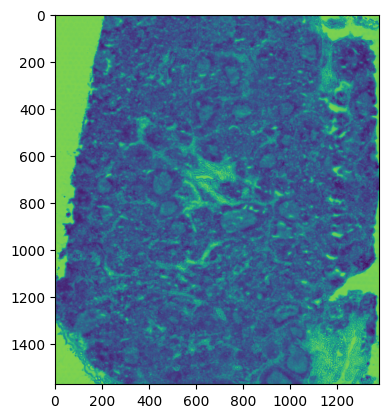

In [9]:
new_hir = img_hires.copy()
coors = adata.obsm['spatial'] * scale_factor
# Find the biggest rectangle
x_min = int(np.min(coors[:, 0]))
x_max = int(np.max(coors[:, 0]))
y_min = int(np.min(coors[:, 1]))
y_max = int(np.max(coors[:, 1]))
spatial_coords = coors

new_hir = new_hir[y_min:y_max, x_min:x_max]
gray_image = cv2.cvtColor((new_hir * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image)

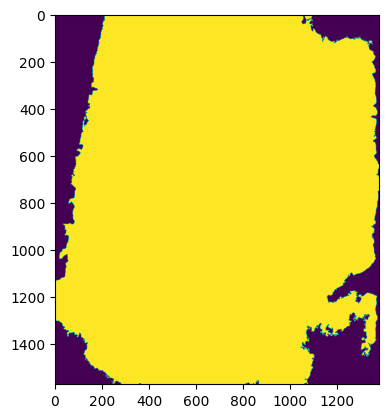

In [10]:
# Apply Otsu's thresholding to segment the tissue
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the binary image so that tissue is white and background is black
binary_image = cv2.bitwise_not(binary_image)

labels = measure.label(binary_image, connectivity=2)
props = measure.regionprops(labels)
largest_region = max(props, key=lambda x: x.area)

# Create a mask for the region with the area larger than the threshold
threshold = 0.1
tissue_mask_list = []
positions = []
for prop in props:
    if prop.area > threshold * largest_region.area:
        tissue_mask_list.append(prop.filled_image)
        positions.append(prop.bbox)

tissue_mask = np.zeros_like(binary_image)
for mask, pos in zip(tissue_mask_list, positions):
    y1, x1, y2, x2 = pos
    tissue_mask[y1:y2, x1:x2] = mask
    
plt.imshow(tissue_mask)


In [11]:
new_hir.shape

(1572, 1380, 3)

In [12]:
# Extract spatial coordinates for each spot (scaled for the hires image)
spatial_coords = adata.obsm['spatial']
spatial_coords = spatial_coords * scale_factor

# Define patch size
patch_size = (26, 26)  # Adjust as needed, but also need to adjust the models if you have changed this
# Find contours of the tissue region
contours, _ = cv2.findContours(tissue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# List to store patch and corresponding spatial spot mapping
patch_spot_mapping = []


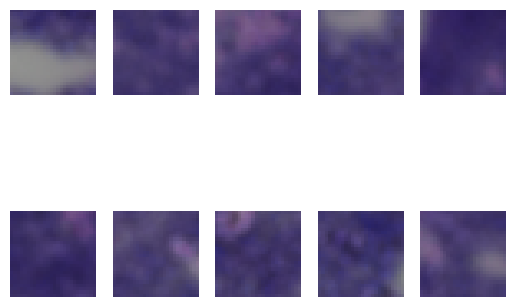

3991


In [13]:
# Extract patches from the tissue region and assign the nearest spatial spot
patches = []
patch_spot_mapping = []
ii=0
for i, spot in enumerate(spatial_coords):
    spot_x, spot_y = spot 
    spot_x = int(spot_x)
    spot_y = int(spot_y)
    
    # and spot_x +patch_size[0]< img_hires.shape[0] and spot_y \ +patch_size[1]< img_hires.shape[1] and \
    #spot_x-x_min<x+w and spot_y-y_min<y+h:
    patch = img_hires[spot_y:spot_y + patch_size[1], spot_x:spot_x + patch_size[0], :]
    
    if patch.shape[0] < patch_size[0] or patch.shape[1] < patch_size[1]:
        patch = cv2.copyMakeBorder(patch, 0, patch_size[0] - patch.shape[0], 0, patch_size[1] - patch.shape[1], cv2.BORDER_CONSTANT, value=0)
    patches.append(patch)
    ii+=1
    patch_spot_mapping.append({
        'patch': patches[len(patches)-1],
        'spot': adata.obs_names[i]
    })
    

for i, entry in enumerate(patch_spot_mapping[:10]):  # Display first 10 patches
    plt.subplot(2, 5, i + 1)
    plt.imshow(entry['patch'])
    #plt.title(f'sp: {entry["spot"]}')
    plt.axis('off')
plt.show()

unique_spots = set()
unique_patch_spot_mapping = []


print(ii)

In [14]:
# # Put the patches back together
# # Create a blank canvas to draw the patches, to visualize the patches on the tissue region

# canvas = np.zeros_like(img_hires)
# for entry in patch_spot_mapping:
#     x, y = np.where(tissue_mask)
#     x, y = x[0], y[0]
#     patch = entry['patch']
#     spot = entry['spot']
#     # Find the spatial coordinates of the spot
#     spot_idx = adata.obs_names.get_loc(spot)
#     spot_x, spot_y = spatial_coords[spot_idx]
#     spot_x = int(spot_x)
#     spot_y = int(spot_y)
#     # Calculate the top-left corner 
#     # coordinates for the patch
#     x1 = spot_x - patch_size[0] // 2
#     x2 = x1 + patch_size[0]
#     y1 = spot_y - patch_size[1] // 2
#     y2 = y1 + patch_size[1]
#     # Draw the patch on the canvas
#     canvas[y1:y2, x1:x2, :] = patch

# plt.imshow(canvas)

In [15]:
# Get the list of spot names from patch_spot_mapping
mapped_spot_names = [entry['spot'] for entry in patch_spot_mapping]
# Find the intersection of spot names between mapped_spot_names and adata.obs_names
common_spots = list(set(mapped_spot_names) & set(adata.obs_names))
# Filter patch_spot_mapping to keep only the common spots
filtered_patch_spot_mapping = [entry for entry in patch_spot_mapping if entry['spot'] in common_spots]
unique_spots = set()

# Filter the patch_spot_mapping to ensure unique spot entries
unique_filtered_patch_spot_mapping = []
for entry in filtered_patch_spot_mapping:
    spot = entry['spot']
    if spot not in unique_spots:
        unique_filtered_patch_spot_mapping.append(entry)
        unique_spots.add(spot)  # Add the spot to the set to track uniqueness


# Separate the spots and patches into two lists
spots = [entry['spot'] for entry in unique_filtered_patch_spot_mapping]  # List of spot names
patches = [entry['patch'] for entry in unique_filtered_patch_spot_mapping]  # List of corresponding patches



patches=np.array(patches)
# Only keep the spots inside the tissue
adata_filtered = adata[adata.obs_names.isin(common_spots)]

output_dir = './results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

adata_filtered.write("./results/"+sample_id+f"{patch_size[0]}*{patch_size[0]}.h5ad")
np.save("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_patches.npy",patches)
np.save("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_spots.npy",spots)

In [16]:
adata_filtered

AnnData object with n_obs × n_vars = 3991 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [17]:
adata_filtered=sc.read("./results/"+sample_id+f"{patch_size[0]}*{patch_size[0]}.h5ad")

img_data=np.load("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_patches.npy")
barcodes=np.load("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_spots.npy")

In [18]:
len(img_data)

3991

In [19]:
adata_filtered

AnnData object with n_obs × n_vars = 3991 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [20]:
import torch
device = torch.device("cuda")
# Convert to PyTorch tensor and change the order of dimensions to (N, C, H, W)
img_tensor = torch.tensor(img_data, dtype=torch.float32).permute(0, 3, 1, 2)

# Normalize the images between [0, 1] if not already done
img_tensor = img_tensor / 255.0 if img_tensor.max() > 1.0 else img_tensor

print(img_tensor.shape)  

torch.Size([3991, 3, 26, 26])


## Origin Autoencoder

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        


        #for patches with size of 50x50 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 50x50x3 -> 25x25x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 25x25x64 -> 13x13x128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 13x13x128 -> 7x7x256
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0),  # 7x7x256 -> 13x13x128
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # 13x13x128 -> 25x25x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=2, output_padding=0),  # 25x25x64 -> 50x50x3
            nn.Sigmoid()  # Use Sigmoid if images are normalized between [0,1]
        )
        #for patches with size of 25x2
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize the model
autoencoder = Autoencoder()

In [22]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img_tensor):
        self.img_tensor = img_tensor

    def __len__(self):
        return len(self.img_tensor)

    def __getitem__(self, idx):
        return self.img_tensor[idx]

# Create the dataset
dataset = CustomImageDataset(img_tensor)

# Create a DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [23]:
import torch.optim as optim

autoencoder = Autoencoder().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        _, output = autoencoder(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

Epoch [1/30], Loss: 0.00103062
Epoch [2/30], Loss: 0.00050321
Epoch [3/30], Loss: 0.00040871
Epoch [4/30], Loss: 0.00031473
Epoch [5/30], Loss: 0.00031269
Epoch [6/30], Loss: 0.00025759
Epoch [7/30], Loss: 0.00025433
Epoch [8/30], Loss: 0.00020826
Epoch [9/30], Loss: 0.00027306
Epoch [10/30], Loss: 0.00021033
Epoch [11/30], Loss: 0.00028149
Epoch [12/30], Loss: 0.00019863
Epoch [13/30], Loss: 0.00017145
Epoch [14/30], Loss: 0.00015984
Epoch [15/30], Loss: 0.00017367
Epoch [16/30], Loss: 0.00011287
Epoch [17/30], Loss: 0.00022502
Epoch [18/30], Loss: 0.00012901
Epoch [19/30], Loss: 0.00011515
Epoch [20/30], Loss: 0.00009846
Epoch [21/30], Loss: 0.00010306
Epoch [22/30], Loss: 0.00010983
Epoch [23/30], Loss: 0.00008312
Epoch [24/30], Loss: 0.00021222
Epoch [25/30], Loss: 0.00012496
Epoch [26/30], Loss: 0.00008082
Epoch [27/30], Loss: 0.00007506
Epoch [28/30], Loss: 0.00005669
Epoch [29/30], Loss: 0.00007306
Epoch [30/30], Loss: 0.00007690


In [24]:
# Switch to evaluation mode
autoencoder.eval()

# Extract features from the encoder
with torch.no_grad():
    features_list = []
    for batch in data_loader:
        batch = batch.to(device)
        features, _ = autoencoder(batch)
        features_list.append(features.cpu())

# Concatenate features from all batches
features_tensor = torch.cat(features_list, dim=0)
print(features_tensor.shape) 


torch.Size([3991, 256, 4, 4])


In [25]:
# Apply global max pooling
features_pooled, _ = torch.max(features_tensor, dim=2)
# Apply max pooling along the width dimension 
features_pooled, _ = torch.max(features_pooled, dim=2)

print(features_pooled.shape)  

torch.Size([3991, 256])


In [26]:
#save the model
torch.save(autoencoder.state_dict(), './results/'+sample_id+'_'+f"{patch_size[0]}_autoencoder.pth")
del autoencoder

In [27]:
# # Load the model
# autoencoder = Autoencoder().to(device)
# autoencoder.load_state_dict(torch.load('./results/'+sample_id+'_'+f"{patch_size[0]}_autoencoder.pth"))

In [28]:
encoded_features=features_pooled.cpu().numpy()
# encoded_features

In [29]:
np.save('./results/'+sample_id+f"_AE_features{patch_size[0]}.npy",encoded_features)

In [30]:
# features_array=np.load('./results/'+sample_id+f"_AE_features{patch_size[0]}.npy")
# #remove all zero columns
# features_array = features_array[:, ~np.all(features_array == 0, axis=0)]
# features_array.shape

## BiGAN
Training may take hours without gpu

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, a=0.2)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Encoder (E)
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            # Input: 3 x 26 x 26
            nn.Conv2d(3, 32, 4, 2, 1),    # Output: 32 x 13 x 13
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),   # Output: 64 x 6 x 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: 128 x 3 x 3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, latent_dim)  
        )
    
    def forward(self, x):
        return self.model(x)

# Generator (G)
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 3 * 3),  
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 3, 3)),        
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # Output: 64 x 6 x 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # Output: 32 x 12 x 12
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # Output: 3 x 24 x 24
            nn.Tanh(),
            nn.Upsample(size=(26, 26), mode='bilinear', align_corners=False)  # 修改为26x26
        )
    
    def forward(self, z):
        return self.model(z)

# Discriminator (D)
class Discriminator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Discriminator, self).__init__()
        # For x
        self.x_net = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),     # Output: 32 x 13 x 13
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),    # Output: 64 x 6 x 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),   # Output: 128 x 3 x 3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 1, 0),  # Output: 256 x 1 x 1
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        # For z
        self.z_net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2)
        )
        # Joint
        self.joint_net = nn.Sequential(
            nn.Linear(256 * 1 * 1 + 128, 512), 
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)  
        )
    
    def forward(self, x, z):
        x_feat = self.x_net(x)
        z_feat = self.z_net(z)
        joint = torch.cat([x_feat, z_feat], dim=1)
        validity = self.joint_net(joint)
        return validity  # Output is scalar value

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
latent_dim = 128
encoder = Encoder(latent_dim).to(device)
generator = Generator(latent_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

# Apply weight initialization
encoder.apply(weights_init)
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (x_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (z_net): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_

In [32]:
# Optimizers
optimizer_E = optim.Adam(encoder.parameters(), lr=3e-4, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=3e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.2, 0.999))

# Loss function
adversarial_loss = nn.BCEWithLogitsLoss()

# Training parameters
num_epochs = 50
batch_size = 64
real_label = 0.9
fake_label = 0.1

data_loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# Training loop
for epoch in range(num_epochs):
    encoder.train()
    generator.train()
    discriminator.train()
    for batch_idx, (batch) in enumerate(data_loader):
        batch = batch.to(device)
        batch_size = batch.size(0)

        # Create labels
        label_real = torch.full(
            (batch_size, 1), real_label, device=device, dtype=torch.float
        )
        label_fake = torch.full(
            (batch_size, 1), fake_label, device=device, dtype=torch.float
        )

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real data
        z_real = torch.randn(batch_size, latent_dim, device=device)
        validity_real = discriminator(batch, z_real)
        loss_D_real = adversarial_loss(validity_real, label_real)

        # Fake data
        z_fake = encoder(batch).detach()
        x_fake = generator(z_fake).detach()
        validity_fake = discriminator(x_fake, z_fake)
        loss_D_fake = adversarial_loss(validity_fake, label_fake)

        # Total Discriminator loss
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

        optimizer_D.step()

        # -----------------
        #  Train Generator and Encoder
        # -----------------
        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        z_fake = encoder(batch)
        x_fake = generator(z_fake)
        validity = discriminator(x_fake, z_fake)
        loss_GE = adversarial_loss(validity, label_real)

        loss_GE.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

        optimizer_E.step()
        optimizer_G.step()

        # Print statistics every 100 batches
        if batch_idx % 100 == 0:
            print(
                f'Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D.item():.4f}, '
                f'Loss GE: {loss_GE.item():.4f}'
            )
            # Optional: Print the mean and std of the Discriminator outputs
            with torch.no_grad():
                print(
                    f'Validity Real Mean: {validity_real.mean().item():.4f}, '
                    f'Std: {validity_real.std().item():.4f}'
                )
                print(
                    f'Validity Fake Mean: {validity_fake.mean().item():.4f}, '
                    f'Std: {validity_fake.std().item():.4f}'
                )
                print(
                    f'Validity GE Mean: {validity.mean().item():.4f}, '
                    f'Std: {validity.std().item():.4f}'
                )

Epoch [1/50], Loss D: 0.9058, Loss GE: 0.5708
Validity Real Mean: 0.0235, Std: 0.9419
Validity Fake Mean: 0.5784, Std: 0.7527
Validity GE Mean: 0.5478, Std: 0.7445
Epoch [2/50], Loss D: 1.3870, Loss GE: 0.3310
Validity Real Mean: -0.0963, Std: 0.7177
Validity Fake Mean: 2.0662, Std: 0.2907
Validity GE Mean: 2.0190, Std: 0.2897
Epoch [3/50], Loss D: 1.3620, Loss GE: 0.3320
Validity Real Mean: -0.2408, Std: 0.5962
Validity Fake Mean: 1.9443, Std: 0.2075
Validity GE Mean: 1.8946, Std: 0.2060
Epoch [4/50], Loss D: 1.4866, Loss GE: 0.3272
Validity Real Mean: -0.1472, Std: 0.6114
Validity Fake Mean: 2.3088, Std: 0.2159
Validity GE Mean: 2.2488, Std: 0.2183
Epoch [5/50], Loss D: 1.5338, Loss GE: 0.3419
Validity Real Mean: -0.3919, Std: 0.6672
Validity Fake Mean: 2.2575, Std: 0.5901
Validity GE Mean: 2.1889, Std: 0.5832
Epoch [6/50], Loss D: 1.6686, Loss GE: 0.3328
Validity Real Mean: -0.5115, Std: 0.6895
Validity Fake Mean: 2.5247, Std: 0.4528
Validity GE Mean: 2.4367, Std: 0.4507
Epoch [7/50

In [33]:
torch.save(encoder.state_dict(), f'./results/{sample_id}_{patch_size[0]}_50l_BIGAN_encoder_new.pth')
torch.save(generator.state_dict(), f'./results/{sample_id}_{patch_size[0]}_50l_BIGAN_generator.pth')
torch.save(discriminator.state_dict(), f'./results/{sample_id}_{patch_size[0]}_50l_BIGAN_discriminator.pth')

In [34]:
load_encoder = Encoder(latent_dim).to(device)

In [35]:
# path = './results/'+sample_id+f"_{patch_size[0]}_50l_BIGAN_encoder_new.pth"
# #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load_encoder.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

In [36]:
# Switch to evaluation mode
load_encoder.eval()

results = []
# Convert to PyTorch tensor and change the order of dimensions to (N, C, H, W)
img_tensor = torch.tensor(img_data, dtype=torch.float32).permute(0, 3, 1, 2)
# Normalize the images between [0, 1] if not already done
img_tensor = img_tensor / 255.0 if img_tensor.max() > 1.0 else img_tensor
img_tensor = img_tensor.to(device)
print(img_tensor.shape)  

#extract features
with torch.no_grad():
    features = load_encoder(img_tensor)
    results.append(features.cpu())

torch.Size([3991, 3, 26, 26])


In [37]:
del encoder
del generator
del discriminator
encoded_features_bigan = torch.cat(results, dim=0)

In [38]:
np.save("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_bigan_new_f.npy",encoded_features_bigan)

In [39]:
# #Load data
# encoded_features_bigan = np.load('./results/'+sample_id+f"_{patch_size[0]}*{patch_size[0]}_bigan_new_f.npy")

## DINO

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm
import torch.nn.functional as F

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class PatchDataset(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]['patch']
        if self.transform:
            patch = self.transform(patch)
        return patch

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the DINO model
model_name_dino = 'vit_base_patch16_224_dino'
student_model = timm.create_model(model_name_dino, pretrained=True)
teacher_model = timm.create_model(model_name_dino, pretrained=True)
teacher_model.load_state_dict(student_model.state_dict())
teacher_model.eval()
teacher_model.to(device)

dataset = PatchDataset(patch_spot_mapping, transform=transform)
batch_size = 16
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

transform_dino = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to 224x224, the input size for DINO
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), 
    transforms.RandomGrayscale(p=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

class DINOImageDatasetFineTunePairs(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = self.img_list[idx]['patch']
        image = Image.fromarray((image * 255).astype(np.uint8))
        if self.transform:
            img1 = self.transform(image)
            img2 = self.transform(image)
        return img1, img2

dino_dataset_finetune = DINOImageDatasetFineTunePairs(unique_filtered_patch_spot_mapping, transform=transform_dino)
dino_data_loader_finetune = DataLoader(dino_dataset_finetune, batch_size=batch_size, shuffle=True, num_workers=0)  #

Device: cuda


In [41]:
# define the contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        N = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)  # [2N, D]
        z_norm = F.normalize(z, dim=1) 
        similarity_matrix = torch.matmul(z_norm, z_norm.T) / self.temperature  # [2N, 2N]

        # create a tensor where diagonal elements are considered positive samples
        labels = torch.arange(N).to(z.device)
        labels = torch.cat([labels + N, labels], dim=0) 

        # compute the cross entropy loss
        mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
        similarity_matrix = similarity_matrix.masked_fill(mask, -1e9)

        loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
        return loss

contrastive_loss = ContrastiveLoss()


class TeacherStudentModel(nn.Module):
    def __init__(self, student, teacher, momentum=0.996):
        super(TeacherStudentModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.momentum = momentum
        self.teacher.eval()  # Teacher is always in eval mode

        for param in self.teacher.parameters():
            param.requires_grad = False  # Teacher does not require gradients

    @torch.no_grad()
    def update_teacher(self):
        for param_s, param_t in zip(self.student.parameters(), self.teacher.parameters()):
            param_t.data = param_t.data * self.momentum + param_s.data * (1. - self.momentum)

    def forward(self, x_s, x_t):
        # Student forward
        features_s = self.student.forward_features(x_s)
        if isinstance(features_s, dict):
            features_s = features_s['cls_token']
        else:
            features_s = features_s[:, 0, :]

        # Teacher forward
        with torch.no_grad():
            features_t = self.teacher.forward_features(x_t)
            if isinstance(features_t, dict):
                features_t = features_t['cls_token']
            else:
                features_t = features_t[:, 0, :] 

        return features_s, features_t

In [42]:
model = TeacherStudentModel(student_model, teacher_model, momentum=0.996).to(device)
model.train()

# define the optimizer and scheduler
optimizer_dino_finetune = optim.Adam(model.student.parameters(), lr=1e-4, weight_decay=1e-4) 
scheduler_dino_finetune = optim.lr_scheduler.CosineAnnealingLR(optimizer_dino_finetune, T_max=15)  

num_epochs_finetune = 15

for epoch in range(num_epochs_finetune):
    epoch_loss = 0
    for img1, img2 in tqdm(dino_data_loader_finetune, desc=f"Finetune DINO v2 Epoch {epoch + 1}/{num_epochs_finetune}"):
        img1 = img1.to(device)
        img2 = img2.to(device)

        optimizer_dino_finetune.zero_grad()

        features_s, features_t = model(img1, img2)

        loss = contrastive_loss(features_s, features_t)
        loss.backward()
        optimizer_dino_finetune.step()

        model.update_teacher()
        

        epoch_loss += loss.item()
        
    scheduler_dino_finetune.step()

    avg_loss = epoch_loss / len(dino_data_loader_finetune)
    print(f"FT epoch [{epoch + 1}/{num_epochs_finetune}], Loss: {avg_loss:.4f}")



Finetune DINO v2 Epoch 1/15: 100%|██████████| 250/250 [06:06<00:00,  1.47s/it]


FT epoch [1/15], Loss: 2.3375


Finetune DINO v2 Epoch 2/15: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s]


FT epoch [2/15], Loss: 1.0350


Finetune DINO v2 Epoch 3/15: 100%|██████████| 250/250 [05:02<00:00,  1.21s/it]


FT epoch [3/15], Loss: 0.4661


Finetune DINO v2 Epoch 4/15: 100%|██████████| 250/250 [04:18<00:00,  1.03s/it]


FT epoch [4/15], Loss: 0.2128


Finetune DINO v2 Epoch 5/15: 100%|██████████| 250/250 [02:44<00:00,  1.52it/s]


FT epoch [5/15], Loss: 0.1447


Finetune DINO v2 Epoch 6/15: 100%|██████████| 250/250 [04:00<00:00,  1.04it/s]


FT epoch [6/15], Loss: 0.0919


Finetune DINO v2 Epoch 7/15: 100%|██████████| 250/250 [01:44<00:00,  2.40it/s]


FT epoch [7/15], Loss: 0.0777


Finetune DINO v2 Epoch 8/15: 100%|██████████| 250/250 [01:17<00:00,  3.23it/s]


FT epoch [8/15], Loss: 0.0493


Finetune DINO v2 Epoch 9/15: 100%|██████████| 250/250 [06:14<00:00,  1.50s/it]


FT epoch [9/15], Loss: 0.0400


Finetune DINO v2 Epoch 10/15: 100%|██████████| 250/250 [02:08<00:00,  1.95it/s]


FT epoch [10/15], Loss: 0.0334


Finetune DINO v2 Epoch 11/15: 100%|██████████| 250/250 [03:52<00:00,  1.08it/s]


FT epoch [11/15], Loss: 0.0227


Finetune DINO v2 Epoch 12/15: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


FT epoch [12/15], Loss: 0.0226


Finetune DINO v2 Epoch 13/15: 100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


FT epoch [13/15], Loss: 0.0158


Finetune DINO v2 Epoch 14/15: 100%|██████████| 250/250 [01:17<00:00,  3.22it/s]


FT epoch [14/15], Loss: 0.0170


Finetune DINO v2 Epoch 15/15: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s]

FT epoch [15/15], Loss: 0.0152


In [43]:

torch.save(model.state_dict(), './results/'+sample_id+f"_{patch_size[0]}_dino.pth")

In [44]:
# extract features
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
new_model = TeacherStudentModel(student_model, teacher_model, momentum=0.996).to(device)
new_model.load_state_dict(torch.load('./results/'+sample_id+f"_{patch_size[0]}_dino.pth", map_location=torch.device('cpu')))

new_model.eval()  
batch_size = 16

transform_dino_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225]) 
])

class DINOImageDatasetEval(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = self.img_list[idx]['patch']
        image = Image.fromarray((image * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        return image
    
dino_dataset_eval = DINOImageDatasetEval(unique_filtered_patch_spot_mapping, transform=transform_dino_eval)
dino_data_loader_eval = DataLoader(dino_dataset_eval, batch_size=batch_size, shuffle=False,
                                   num_workers=0)

with torch.no_grad():
    features_list_dino = []
    for images in tqdm(dino_data_loader_eval, desc="Extract features"):
        images = images.to(device)
        features = new_model.student.forward_features(images)

        if isinstance(features, dict):
            features = features['cls_token']
        else:
            features = features[:, 0, :]  

        features_list_dino.append(features.cpu())
        
features_tensor_dino = torch.cat(features_list_dino, dim=0)
features_array_dino = features_tensor_dino.numpy()

Device: cuda


Extract features: 100%|██████████| 250/250 [01:51<00:00,  2.25it/s]


In [45]:
# save raw features
np.save('./results/'+sample_id+f"_{patch_size[0]}*{patch_size[0]}_features_array_dino.npy",features_array_dino)

In [46]:
# # load raw features
# features_array_dino = np.load('./results/'+sample_id+f"_{patch_size[0]}*{patch_size[0]}_features_array_dino.npy")
# features_array_dino = features_array_dino[:, ~np.all(features_array_dino == 0, axis=0)]